# NIFTY IT Index Forecasting with LSTM Networks

In this problem, we will be working on the daily close price data of NIFTY IT Index. We would try to build a forecastinh model to predict  the close prices. The data contains daily open, close, high, low , volume etc. data for the index. For this study we will work on with the close prices only. The data set contains data from 1st Jan, 2018 to 31st December, 2018. 

Let's first load all the necessary libraries in our workspace.

In [1]:
######  Loading libraries ############
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler

At the start of the analysis, it's good idea to set random seeds to a constant value for the reproducibility of the results. Most of the machine learning algorithms involve steps with random value generation. Thus, setting seed is good when we want to reproduce the same results later. Also, clearing out TensorFlow session is another safety check.

In [2]:
######### Setting Seeds ####### 
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)

Next, we read in the .csv file containing the data. In the second line we drop all the rows with NA values for daily close price. Finally, we store the clsoe price data in another variable x for further analysis.

In [3]:
#### Reading in the data ########
data=pd.read_csv('nifty_it_index.csv')
data=data[data['Close'].notna()]

x=data['Close']

As with most machine learning problems, we build the model on training dataset and the check the performance of our model on test dataset. Here we build the model on first 11 months data and check accuracy on last months data. To split the data in train and test we use split index. This ensures if we want to change the train-test split then we just need to change this variable.

Also, for most of the Neural networks it is suggested to normalize the data before using it as input. So, in this case we use a min max scaler which projects the daily clsoe price data between 0 to 1. Simply put, the minimum value is considered 0 and maximum is 1 and all other values in between is scaled accordingly.

Apart from using this transformation based on the training  data, we also use the same to transform the whole data, so test data is also scaled using the same scale. We will need this while using the model to predict future stock prices.

In [4]:
#### Splitting the dataset in Train and test set ########
split_index=226  
price_train=x[:split_index]
price_test=x[split_index:]

sc = MinMaxScaler(feature_range=(0,1))
price_train_scaled=price_train.to_numpy()
price_train_scaled = sc.fit_transform(price_train_scaled.reshape(-1,1))
price_train_scaled=price_train_scaled.flatten()

x_scale=sc.fit_transform(x.to_numpy().reshape(-1,1)).flatten()

Before going ahead with heavy-lifting machine learnign algorithms we should come up with some base line model. This will help us in determining whether the model improves on this naive model or not. For any forecasting problem, the most naive prediction can be the most recent value available. In a way, most naive prediction about tomorrow's temperature would be today's temperature. If we look at it closely, this isn't that bad a guess. If yesterday's average temperature was 30 degrees celcius, then today's temperature would most likely be between 27-33 degrees, unless there is some rainfall. In a way this naive predictions give us a good reference point to check our model performance.

To check the accuracy of the model we use two metrics, *i.e.* Mean absolute error and mean squared error. We also write a small function to calculate this values. Writing these type small functions helps, if that task is performed repeatedly in our analysis. We will again use these metric to evaluate our model, so it is better to write a small function.

In [8]:
##### Naive-Prediction #####################

def error_metrics(y_pred,y_actual):
    return mean_absolute_error(y_actual, y_pred),mean_squared_error(y_actual,y_pred)

forecast_naive=x[split_index-1:len(x)-1]
mae_naive, mse_naive=error_metrics(forecast_naive,price_test)
print("MAE="+str(mae_naive.round(2)))
print("MSE="+str(mse_naive.round(2)))

MAE=78.17
MSE=8016.3


Next, for the LSTM (Long short term memory) we need to transform our dataset. For this purpose, we divide the dataset in rolling window of 21, where first 20 values are used to predict the 21st value. This is how we transform the forecasting problem into a supervised learning problem. Again, we write a function to perform this task.

Here we use a window size of 20, which means almost 4 weeks (5 working days per day) of data is used to forecast the next day's closing price. Other parameters are batch size and suffle buffer size. Batch size is the number of training examples used in each iteration of training the model. Also, we shuffle this windowed batches of training examples so that the training process is not sequence dependent.

In [10]:
###### Windowed batch data set creation ############
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 20
batch_size = 32
shuffle_buffer_size = 100
dataset = windowed_dataset(price_train_scaled, window_size, batch_size, shuffle_buffer_size)

Next we create the model architecture. Here we use 3 layers of unidirectional LSTM layers with Relu activation function. Point to note, for first two layers we use return_sequence=True, this means this two layers output a sequence rather than a single number. But the last layer gives one single number.

We use MAE as loss function and Adam optimizer for the training purpose. 

In [11]:
###### Model setup ##########

model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.LSTM(32, return_sequences=True,activation="relu"),
  tf.keras.layers.LSTM(32, return_sequences=True,activation="relu"),
  tf.keras.layers.LSTM(32,activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()
model_lstm.compile(loss="mae", optimizer=optimizer,metrics=["mae"])

Finally, we train the model. At first we use 200 epochs for the training purpose. This can be decided based on the results from the training process. Also, we supress the output from training process using verbose to 0 for brevity in this case.

Also, let's save the results from the trainig process in two variables for further evaluation purpose.

In [12]:
######## Training the model ############
history_lstm=model_lstm.fit(dataset,epochs=200,verbose=0,shuffle=False)

mae=history_lstm.history['mae']
loss=history_lstm.history['loss']

Once, the trainng is complete we need to do some diagnostics. For this purpose we plot the loss function across the epochs. We see the loss function decreases quite a lot till epoch 150 and then flattens out. This is more pronounced when we zoom on in last 50 epochs. We can see in last 50 epochs the loss function doesn't decrease, thus we can conclude that in this case training  till 200 epochs is enough. If the loss function was still decreasing then we need to incraese the epochs and train the model again.

Once again, we build two plotting functions for our tasks. This is helpful becasuse in most practical cases we need to try out different architectures, loss functions, optimizers and hyper parameters. Thus, having these kind of functions is pretty handy.

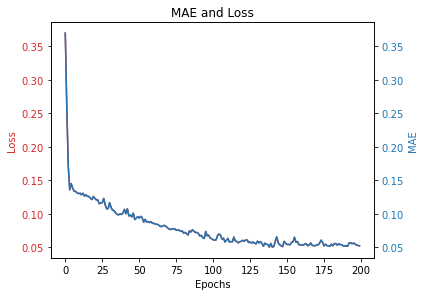

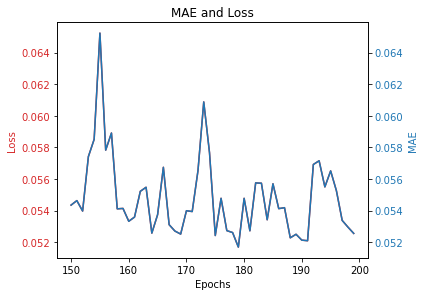

In [13]:
########## Post training diagnostics #############
def plot_accuracy_epoch(epochs,loss,acc_metric):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()     
    color = 'tab:blue'
    ax2.set_ylabel('MAE', color=color) 
    ax2.plot(epochs, acc_metric, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout() 
    plt.title('MAE and Loss')
    plt.show()

def plot_zoom(from_epoch):
    epochs_zoom = epochs[from_epoch:]
    mae_zoom = mae[from_epoch:]
    loss_zoom = loss[from_epoch:]

    plot_accuracy_epoch(epochs_zoom,loss_zoom,mae_zoom)  

epochs=range(len(loss))

plot_accuracy_epoch(epochs,loss,mae)
plot_zoom(150)

Now, we need to forecast the daily close prices for next 1 month. For this we will again use windowed dataset of last 20 days data as input to pur model. Moreover, we need to inverse transform results from our forecast to compare with actual data of the last month's closing stock prices.

In [14]:
###### Forecasting ##############

forecast_lstm = []
for i in range(len(price_test)):
  forecast_lstm.append(model_lstm.predict([[x_scale[len(price_train)-window_size+i:len(price_train)+i]]])[0][0])

forecast_lstm=np.array(forecast_lstm).reshape(-1,1)
forecast_lstm = sc.inverse_transform(forecast_lstm).flatten()

The moment of truth has arrived. We need to compare the performance of our model against the performance of the naive model. We use the same two error metrics as used earlier.

In [15]:
######  Model Performance ############
mae_lstm, mse_lstm=error_metrics(forecast_lstm,price_test)
print("MAE="+str(mae_lstm.round(2)))
print("MSE="+str(mse_lstm.round(2)))

MAE=73.12
MSE=9093.47


As we can see from the result, our model improves on the MAE metric but not on the other metric. We used MAE as the loss function also in this case, which could be a determining factor. This also shows, heavy-duty deep learning models may not be best for all applications. In some cases good old ARIMA or Holt-Winter's could give us better results. Thus, we need to build and evaluate performance across different models.

Finally, we check the actual and forecasted values side by side on a plot to check our model performance. This suggeests although model performs quite well in capturing the overall trend, but the sudden sharp rise and falls are not well captured in this case.

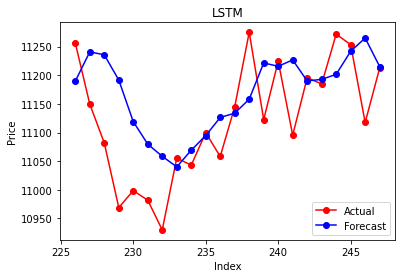

<Figure size 432x288 with 0 Axes>

In [17]:
############ Actual vs Forecast ###########
def plot_forecast(actual,forecast,title):
    plt.plot(list(actual.index), actual, '-o' ,color='r')
    plt.plot(list(actual.index), forecast, '-o', color='b')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend(["Actual", "Forecast"])
    plt.figure()
    
plot_forecast(price_test, forecast_lstm,'LSTM')


Forecasting is always been a hard problem. Moreover, stock prices have been very hard to predict, otherwise people with machine learning models would have made a fortune in the stock market. Here, we just try a simple LSTM network with limited data to show the whole process. More complex architecture, more data and lot more hyper-parameter tuning may yield better model performance but that's not a gurantee.